In [1]:
from metrics import WordExact, WordLength

from datasets import DatasetDict, Dataset
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator
import torch
from torchmetrics.text import EditDistance
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer
from tqdm.auto import tqdm

In [2]:
def extract_tensorboard_data(log_path, tag):
    steps = []
    values = []
    
    for event in summary_iterator(log_path):
        for value in event.summary.value:
            if value.tag == tag:
                steps.append(event.step)
                values.append(value.simple_value)

    data = pd.DataFrame({"step": steps, "value": values})
    return data

In [3]:
log_path = 'runs/experiment_3/logs/events.out.tfevents.1731002654.3ad969cb0398.9871.0'
checkpoint_path = "runs/experiment_3/checkpoints/checkpoint.pth"


eval_loss = extract_tensorboard_data(log_path, 'eval/loss')
eval_exact = extract_tensorboard_data(log_path, 'eval/exact')
eval_length = extract_tensorboard_data(log_path, 'eval/length')
eval_edit = extract_tensorboard_data(log_path, 'eval/edit')

train_loss = extract_tensorboard_data(log_path, 'train/loss').rolling(window=100).mean()
train_exact = extract_tensorboard_data(log_path, 'train/exact').rolling(window=100).mean()
train_length = extract_tensorboard_data(log_path, 'train/length').rolling(window=100).mean()
train_edit = extract_tensorboard_data(log_path, 'train/edit').rolling(window=100).mean()

learning_rate = extract_tensorboard_data(log_path, 'learning_rate')

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


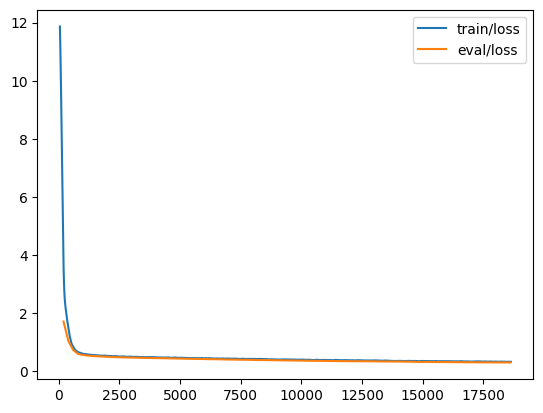

In [4]:
plt.plot(train_loss.step, train_loss.value, label='train/loss')
plt.plot(eval_loss.step, eval_loss.value, label='eval/loss')
plt.legend()
plt.show()

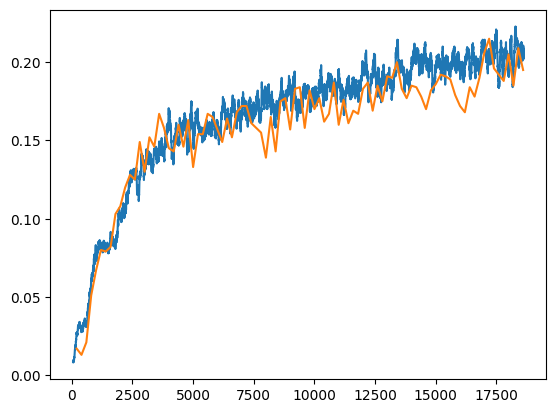

In [5]:
plt.plot(train_length.step, train_length.value, label='train/length')
plt.plot(eval_length.step, eval_length.value, label='eval/length')
plt.show()

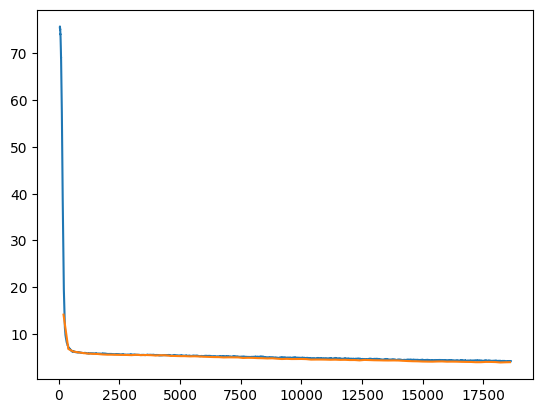

In [6]:
plt.plot(train_edit.step, train_edit.value, label='train/edit')
plt.plot(eval_edit.step, eval_edit.value, label='eval/edit')
plt.show()

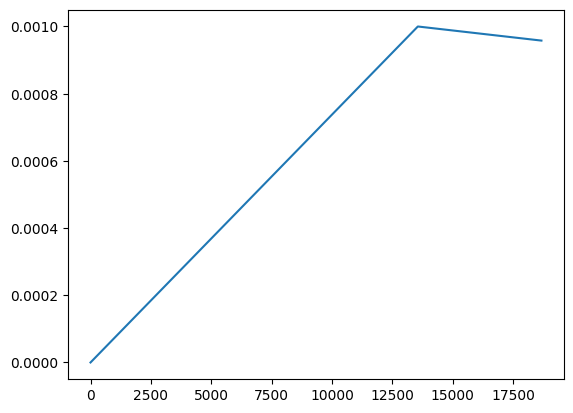

In [7]:
plt.plot(learning_rate.step, learning_rate.value)
plt.show()

In [9]:
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.load_state_dict(checkpoint['model_state_dict'])

tokenizer = T5Tokenizer.from_pretrained("t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [10]:
def tokenize_function(example):
    inputs = tokenizer(example["clue"], truncation=True, max_length=96, padding="max_length")
    targets = tokenizer(example["answer"], truncation=True, max_length=32, padding="max_length")

    return {
        "input_ids": inputs.input_ids,
        "attention_mask": inputs.attention_mask,
        "labels": targets.input_ids
    }

In [11]:
raw_datasets = DatasetDict(
    {
        "train": Dataset.from_pandas(pd.read_csv("data/train.csv")),
        "eval": Dataset.from_pandas(pd.read_csv("data/eval.csv")),
    }
)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["clue", "answer"])
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/433821 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [12]:
train_loader = DataLoader(tokenized_datasets["train"], batch_size=128, shuffle=False)
eval_loader = DataLoader(tokenized_datasets["eval"], batch_size=128, shuffle=False)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.eval()
model.to(device)

train_exact_metric = WordExact()
train_length_metric = WordLength()
train_edit_metric = EditDistance()

for batch in tqdm(train_loader):
    batch = {k:v.to(device) for k,v in batch.items()}
    output = model.generate(**batch, max_new_tokens=20)
    predictions = tokenizer.batch_decode(output, skip_special_tokens=True)
    
    labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
    
    train_exact_metric.update(labels, predictions)
    train_edit_metric.update(labels, predictions)
    train_length_metric.update(labels, predictions)

  0%|          | 0/3390 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pytorch_utils.py:325: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


In [ ]:
train_exact = train_exact_metric.compute()
train_length = train_length_metric.compute()
train_edit = train_edit_metric.compute()


In [ ]:
print(f"Train Exact: {100*train_exact:.4f}%")
print(f"Train Length: {100*train_length:.2f}%")
print(f"Train Edit: {
train_edit:.2f}")

Train Exact: 0.0791%

Train Length: 36.49%

Train Edit: 5.94

Train Exact: 0.8063%

Train Length: 76.17%

Train Edit: 5.66

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.eval()
model.to(device)

eval_exact_metric = WordExact()
eval_length_metric = WordLength()
eval_edit_metric = EditDistance()

for batch in tqdm(eval_loader):
    batch = {k:v.to(device) for k,v in batch.items()}
    output = model.generate(**batch, max_new_tokens=20)
    predictions = tokenizer.batch_decode(output, skip_special_tokens=True)
    
    labels = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
    
    eval_exact_metric.update(labels, predictions)
    eval_edit_metric.update(labels, predictions)
    eval_length_metric.update(labels, predictions)

In [ ]:
eval_exact = eval_exact_metric.compute()
eval_length = eval_length_metric.compute()
eval_edit = eval_edit_metric.compute()

In [ ]:
print(f"Eval Exact: {100*eval_exact:.4f}%")
print(f"Eval Length: {100*eval_length:.2f}%")
print(f"Eval Edit: {eval_edit:.2f}")

Eval Exact: 0.0720%

Eval Length: 36.79%

Eval Edit: 5.94

Eval Exact: 0.6620%

Eval Length: 76.11%

Eval Edit: 5.68